In [0]:
'''Imports'''
import torch
import torch.nn as nn
from torch.nn import init
from torchvision import models
import torch.nn.functional as F
import random
random.seed(350)
import numpy as np
from torchvision import transforms, utils
import matplotlib.pyplot as plt
% matplotlib inline
import torch.optim as optim
from google.colab import output, drive
from torch.autograd import Variable
from PIL import Image
import os
import csv
from torch.distributions.normal import Normal
from torch.optim import Optimizer
from torch.utils.data import Dataset, DataLoader
from functools import partial
from os.path import join, exists
from os import mkdir
from tqdm import tqdm
import math
import gym
import gym.envs.box2d

# Make train results reproducible
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

use_cuda = torch.cuda.is_available()
device_use = torch.device("cuda" if use_cuda else "cpu")
print(device_use, ' used...')
!nvidia-smi

cuda  used...
Sat May 16 10:56:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    26W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Mem

# Connect to google drive in order to save model parameters e.t.c.

In [0]:
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/
!mkdir BACR_Project
%cd BACR_Project
output.clear()
!pwd

/content/drive/My Drive/BACR_Project


# Convolutional Variational AutoEncoder

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

class ConvVAE(nn.Module):
    def __init__(self, image_channels = 3, hidden_dim = 1024, latent_dim=32, kl_tolerance = 0.5):

        '''
        Args:
            image_channels: A integer indicating the number of channels in image.
            hidden_dim: A integer indicating the size of hidden dimension.
            latent_dim: A integer indicating the latent size.
        '''
        super(ConvVAE, self).__init__()

        self.latent_dim = latent_dim
        self.kl_tolerance = kl_tolerance

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=32, kernel_size=4, stride = 2),
            nn.ReLU(True),

            nn.Conv2d(in_channels=32,out_channels= 64, kernel_size = 4, stride = 2),
            nn.ReLU(True),

            nn.Conv2d(in_channels=64,out_channels= 128, kernel_size = 4, stride = 2),
            nn.ReLU(True),

            nn.Conv2d(in_channels=128,out_channels= 256, kernel_size = 4, stride = 2),
            nn.ReLU(True),
            Flatten()
        )

        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(in_channels=hidden_dim,out_channels= 128, kernel_size = 5, stride = 2),
            nn.ReLU(True),
           
            nn.ConvTranspose2d(in_channels=128,out_channels= 64, kernel_size = 5, stride = 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=64,out_channels= 32, kernel_size = 6, stride = 2),
            nn.ReLU(True),
           
            nn.ConvTranspose2d(in_channels=32,out_channels= image_channels, kernel_size = 6, stride = 2),
            nn.Sigmoid()
        )

        self.fc1 = nn.Linear(hidden_dim, latent_dim)

        self.fc3 = nn.Linear(latent_dim, hidden_dim)

    def encode(self, x):
        conv = self.encoder(x)
        h1 = self.fc1(conv)
        return h1, h1

    def decode(self, z):
        
        deconv_input = self.fc3(z)
        deconv_input = deconv_input.view(-1,1024,1,1)
        return self.decoder(deconv_input)

    def reparametrize(self, mu, logvar):
        sigma = logvar.exp()
        eps = torch.randn_like(sigma)
        return  eps.mul(sigma).add_(mu)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar, z  

    def architecture(self):
        return ConvVAE().to(self.used_device)

    def loss(self, decoded, x, mu, logsigma):
        # BCE =  F.binary_cross_entropy(decoded, x, reduction='sum')
        BCE = torch.sum(torch.square((decoded-x)))
        reconstruct_loss = BCE
        KLD = -0.5 * torch.sum((1 + 2*logsigma - mu**2 - (2*logsigma).exp()))
        KLD = torch.max(KLD, torch.Tensor([self.kl_tolerance * self.latent_dim]).cuda())
        KLD = torch.mean(KLD)
        regularization_loss = KLD
        loss = reconstruct_loss + regularization_loss
        return loss

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
read_and_resize = transforms.Compose([            
     transforms.Resize(64),                    
     transforms.ToTensor(),   
    #  transforms.Normalize(mean=(0.5,), std=(0.5,))
    ]) # transofrmation for images in order to allow them be input for our NN model.

### Using trained VAE

In [0]:
model_file = 'VAE/CVAE500.pt'
CVAE_learned = ConvVAE().to(device_use)
CVAE_learned.load_state_dict(torch.load(model_file))
''' 
Inputs: tensor images (BSIZEx3x64x64)
Ouputs: decoded,
         mu, 
        logvar,
         z
         '''
         

' \nInputs: tensor images (BSIZEx3x64x64)\nOuputs: decoded,\n         mu, \n        logvar,\n         z\n         '

# MDN-RNN

In [0]:
def gmm_loss(batch, mus, sigmas, logpi, reduce=True): # pylint: disable=too-many-arguments
    """ Computes the gmm loss.
    Compute minus the log probability of batch under the GMM model described
    by mus, sigmas, pi. Precisely, with bs1, bs2, ... the sizes of the batch
    dimensions (several batch dimension are useful when you have both a batch
    axis and a time step axis), gs the number of mixtures and fs the number of
    features.
    # pi is distribution 
    :args batch: (bs1, bs2, *, fs) torch tensor
    :args mus: (bs1, bs2, *, gs, fs) torch tensor
    :args sigmas: (bs1, bs2, *, gs, fs) torch tensor
    :args logpi: (bs1, bs2, *, gs) torch tensor
    :args reduce: if not reduce, the mean in the following formula is ommited
    :returns:
    loss(batch) = - mean_{i1=0..bs1, i2=0..bs2, ...} log(
        sum_{k=1..gs} pi[i1, i2, ..., k] * N(
            batch[i1, i2, ..., :] | mus[i1, i2, ..., k, :], sigmas[i1, i2, ..., k, :]))
    NOTE: The loss is not reduced along the feature dimension (i.e. it should scale ~linearily
    with fs).
    """
    batch = batch.unsqueeze(-2)
    normal_dist = Normal(mus, sigmas)
    g_log_probs = normal_dist.log_prob(batch)
    g_log_probs = logpi + torch.sum(g_log_probs, dim=-1)
    max_log_probs = torch.max(g_log_probs, dim=-1, keepdim=True)[0]
    g_log_probs = g_log_probs - max_log_probs

    g_probs = torch.exp(g_log_probs)
    probs = torch.sum(g_probs, dim=-1)

    log_prob = max_log_probs.squeeze() + torch.log(probs)
    if reduce:
        return - torch.mean(log_prob)
    return - log_prob

class _MDRNNBase(nn.Module):
    def __init__(self, latents, actions, hiddens, gaussians):
        super().__init__()
        self.latents = latents
        self.actions = actions
        self.hiddens = hiddens
        self.gaussians = gaussians

        self.gmm_linear = nn.Linear(
            hiddens, (2 * latents + 1) * gaussians + 2)

    def forward(self, *inputs):
        pass

class MDRNN(_MDRNNBase):
    """ MDRNN model for multi steps forward """
    def __init__(self, latents, actions, hiddens, gaussians):
        super().__init__(latents, actions, hiddens, gaussians)
        self.rnn = nn.LSTM(latents + actions, hiddens)

    def forward(self, actions, latents): # pylint: disable=arguments-differ
        """ MULTI STEPS forward.
        :args actions: (SEQ_LEN, BSIZE, ASIZE) torch tensor
        :args latents: (SEQ_LEN, BSIZE, LSIZE) torch tensor
        :returns: mu_nlat, sig_nlat, pi_nlat, rs, ds, parameters of the GMM
        prediction for the next latent, gaussian prediction of the reward and
        logit prediction of terminality.
            - mu_nlat: (SEQ_LEN, BSIZE, N_GAUSS, LSIZE) torch tensor
            - sigma_nlat: (SEQ_LEN, BSIZE, N_GAUSS, LSIZE) torch tensor
            - logpi_nlat: (SEQ_LEN, BSIZE, N_GAUSS) torch tensor
            - rs: (SEQ_LEN, BSIZE) torch tensor
            - ds: (SEQ_LEN, BSIZE) torch tensor
        """
        seq_len, bs = actions.size(0), actions.size(1)

        ins = torch.cat([actions, latents], dim=-1)
        outs, _ = self.rnn(ins)
        gmm_outs = self.gmm_linear(outs)

        stride = self.gaussians * self.latents

        mus = gmm_outs[:, :, :stride]
        mus = mus.view(seq_len, bs, self.gaussians, self.latents)

        sigmas = gmm_outs[:, :, stride:2 * stride]
        sigmas = sigmas.view(seq_len, bs, self.gaussians, self.latents)
        sigmas = torch.exp(sigmas)

        pi = gmm_outs[:, :, 2 * stride: 2 * stride + self.gaussians]
        pi = pi.view(seq_len, bs, self.gaussians)
        logpi = F.log_softmax(pi, dim=-1)

        rs = gmm_outs[:, :, -2]

        ds = gmm_outs[:, :, -1]

        return mus, sigmas, logpi, rs, ds

class MDRNNCell(_MDRNNBase):
    """ MDRNN model for one step forward """
    def __init__(self, latents, actions, hiddens, gaussians):
        super().__init__(latents, actions, hiddens, gaussians)
        self.rnn = nn.LSTMCell(latents + actions, hiddens)

    def forward(self, action, latent, hidden): # pylint: disable=arguments-differ
        """ ONE STEP forward.
        :args actions: (BSIZE, ASIZE) torch tensor
        :args latents: (BSIZE, LSIZE) torch tensor
        :args hidden: (BSIZE, RSIZE) torch tensor
        :returns: mu_nlat, sig_nlat, pi_nlat, r, d, next_hidden, parameters of
        the GMM prediction for the next latent, gaussian prediction of the
        reward, logit prediction of terminality and next hidden state.
            - mu_nlat: (BSIZE, N_GAUSS, LSIZE) torch tensor
            - sigma_nlat: (BSIZE, N_GAUSS, LSIZE) torch tensor
            - logpi_nlat: (BSIZE, N_GAUSS) torch tensor
            - rs: (BSIZE) torch tensor
            - ds: (BSIZE) torch tensor
        """
        in_al = torch.cat([action, latent], dim=1)

        next_hidden = self.rnn(in_al, hidden)
        out_rnn = next_hidden[0]

        out_full = self.gmm_linear(out_rnn)

        stride = self.gaussians * self.latents

        mus = out_full[:, :stride]
        mus = mus.view(-1, self.gaussians, self.latents)

        sigmas = out_full[:, stride:2 * stride]
        sigmas = sigmas.view(-1, self.gaussians, self.latents)
        sigmas = torch.exp(sigmas)

        pi = out_full[:, 2 * stride:2 * stride + self.gaussians]
        pi = pi.view(-1, self.gaussians)
        logpi = F.log_softmax(pi, dim=-1)

        r = out_full[:, -2]

        d = out_full[:, -1]

        return mus, sigmas, logpi, r, d, next_hidden

# Utils

In [0]:
""" Various auxiliary utilities """

# A bit dirty: manually change size of car racing env
#gym.envs.box2d.car_racing.STATE_W, gym.envs.box2d.car_racing.STATE_H = 64, 64

# Hardcoded for now
ASIZE, LSIZE, RSIZE, RED_SIZE, SIZE =\
    3, 32, 256, 64, 64

# Same
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((RED_SIZE, RED_SIZE)),
    transforms.ToTensor()
])


def save_checkpoint(state, is_best, filename, best_filename):
    """ Save state in filename. Also save in best_filename if is_best. """
    torch.save(state, filename)
    if is_best:
        torch.save(state, best_filename)

class EarlyStopping(object): # pylint: disable=R0902
    """
    Gives a criterion to stop training when a given metric is not
    improving anymore
    Args:
        mode (str): One of `min`, `max`. In `min` mode, training will
            be stopped when the quantity monitored has stopped
            decreasing; in `max` mode it will be stopped when the
            quantity monitored has stopped increasing. Default: 'min'.
        patience (int): Number of epochs with no improvement after
            which training is stopped. For example, if
            `patience = 2`, then we will ignore the first 2 epochs
            with no improvement, and will only stop learning after the
            3rd epoch if the loss still hasn't improved then.
            Default: 10.
        threshold (float): Threshold for measuring the new optimum,
            to only focus on significant changes. Default: 1e-4.
        threshold_mode (str): One of `rel`, `abs`. In `rel` mode,
            dynamic_threshold = best * ( 1 + threshold ) in 'max'
            mode or best * ( 1 - threshold ) in `min` mode.
            In `abs` mode, dynamic_threshold = best + threshold in
            `max` mode or best - threshold in `min` mode. Default: 'rel'.
    """

    def __init__(self, mode='min', patience=10, threshold=1e-4, threshold_mode='rel'):
        self.patience = patience
        self.mode = mode
        self.threshold = threshold
        self.threshold_mode = threshold_mode
        self.best = None
        self.num_bad_epochs = None
        self.mode_worse = None  # the worse value for the chosen mode
        self.is_better = None
        self.last_epoch = -1
        self._init_is_better(mode=mode, threshold=threshold,
                             threshold_mode=threshold_mode)
        self._reset()

    def _reset(self):
        """Resets num_bad_epochs counter and cooldown counter."""
        self.best = self.mode_worse
        self.num_bad_epochs = 0

    def step(self, metrics, epoch=None):
        """ Updates early stopping state """
        current = metrics
        if epoch is None:
            epoch = self.last_epoch = self.last_epoch + 1
        self.last_epoch = epoch

        if self.is_better(current, self.best):
            self.best = current
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1

    @property
    def stop(self):
        """ Should we stop learning? """
        return self.num_bad_epochs > self.patience


    def _cmp(self, mode, threshold_mode, threshold, a, best): # pylint: disable=R0913, R0201
        if mode == 'min' and threshold_mode == 'rel':
            rel_epsilon = 1. - threshold
            return a < best * rel_epsilon

        elif mode == 'min' and threshold_mode == 'abs':
            return a < best - threshold

        elif mode == 'max' and threshold_mode == 'rel':
            rel_epsilon = threshold + 1.
            return a > best * rel_epsilon

        return a > best + threshold

    def _init_is_better(self, mode, threshold, threshold_mode):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if threshold_mode not in {'rel', 'abs'}:
            raise ValueError('threshold mode ' + threshold_mode + ' is unknown!')

        if mode == 'min':
            self.mode_worse = float('inf')
        else:  # mode == 'max':
            self.mode_worse = (-float('inf'))

        self.is_better = partial(self._cmp, mode, threshold_mode, threshold)

    def state_dict(self):
        """ Returns early stopping state """
        return {key: value for key, value in self.__dict__.items() if key != 'is_better'}

    def load_state_dict(self, state_dict):
        """ Loads early stopping state """
        self.__dict__.update(state_dict)
        self._init_is_better(mode=self.mode, threshold=self.threshold,
                             threshold_mode=self.threshold_mode)


In [0]:
############################################################
#### WARNING : THIS IS A TEMPORARY CODE WHICH HAS      #####
####  TO BE REMOVED WITH PYTORCH 0.5                   #####
#### IT IS COPY OF THE 0.5 VERSION OF THE LR SCHEDULER #####
############################################################
class ReduceLROnPlateau(object): # pylint: disable=R0902
    """Reduce learning rate when a metric has stopped improving.
    Models often benefit from reducing the learning rate by a factor
    of 2-10 once learning stagnates. This scheduler reads a metrics
    quantity and if no improvement is seen for a 'patience' number
    of epochs, the learning rate is reduced.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        mode (str): One of `min`, `max`. In `min` mode, lr will
            be reduced when the quantity monitored has stopped
            decreasing; in `max` mode it will be reduced when the
            quantity monitored has stopped increasing. Default: 'min'.
        factor (float): Factor by which the learning rate will be
            reduced. new_lr = lr * factor. Default: 0.1.
        patience (int): Number of epochs with no improvement after
            which learning rate will be reduced. For example, if
            `patience = 2`, then we will ignore the first 2 epochs
            with no improvement, and will only decrease the LR after the
            3rd epoch if the loss still hasn't improved then.
            Default: 10.
        verbose (bool): If ``True``, prints a message to stdout for
            each update. Default: ``False``.
        threshold (float): Threshold for measuring the new optimum,
            to only focus on significant changes. Default: 1e-4.
        threshold_mode (str): One of `rel`, `abs`. In `rel` mode,
            dynamic_threshold = best * ( 1 + threshold ) in 'max'
            mode or best * ( 1 - threshold ) in `min` mode.
            In `abs` mode, dynamic_threshold = best + threshold in
            `max` mode or best - threshold in `min` mode. Default: 'rel'.
        cooldown (int): Number of epochs to wait before resuming
            normal operation after lr has been reduced. Default: 0.
        min_lr (float or list): A scalar or a list of scalars. A
            lower bound on the learning rate of all param groups
            or each group respectively. Default: 0.
        eps (float): Minimal decay applied to lr. If the difference
            between new and old lr is smaller than eps, the update is
            ignored. Default: 1e-8.
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = ReduceLROnPlateau(optimizer, 'min')
        >>> for epoch in range(10):
        >>>     train(...)
        >>>     val_loss = validate(...)
        >>>     # Note that step should be called after validate()
        >>>     scheduler.step(val_loss)
    """

    def __init__(self, optimizer, mode='min', factor=0.1, patience=10, # pylint: disable=R0913
                 verbose=False, threshold=1e-4, threshold_mode='rel',
                 cooldown=0, min_lr=0, eps=1e-8):

        if factor >= 1.0:
            raise ValueError('Factor should be < 1.0.')
        self.factor = factor

        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        if isinstance(min_lr, (list, tuple)):
            if len(min_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} min_lrs, got {}".format(
                    len(optimizer.param_groups), len(min_lr)))
            self.min_lrs = list(min_lr)
        else:
            self.min_lrs = [min_lr] * len(optimizer.param_groups)

        self.patience = patience
        self.verbose = verbose
        self.cooldown = cooldown
        self.cooldown_counter = 0
        self.mode = mode
        self.threshold = threshold
        self.threshold_mode = threshold_mode
        self.best = None
        self.num_bad_epochs = None
        self.mode_worse = None  # the worse value for the chosen mode
        self.is_better = None
        self.eps = eps
        self.last_epoch = -1
        self._init_is_better(mode=mode, threshold=threshold,
                             threshold_mode=threshold_mode)
        self._reset()

    def _reset(self):
        """Resets num_bad_epochs counter and cooldown counter."""
        self.best = self.mode_worse
        self.cooldown_counter = 0
        self.num_bad_epochs = 0

    def step(self, metrics, epoch=None):
        """ Updates scheduler state """
        current = metrics
        if epoch is None:
            epoch = self.last_epoch = self.last_epoch + 1
        self.last_epoch = epoch

        if self.is_better(current, self.best):
            self.best = current
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1

        if self.in_cooldown:
            self.cooldown_counter -= 1
            self.num_bad_epochs = 0  # ignore any bad epochs in cooldown

        if self.num_bad_epochs > self.patience:
            self._reduce_lr(epoch)
            self.cooldown_counter = self.cooldown
            self.num_bad_epochs = 0

    def _reduce_lr(self, epoch):
        for i, param_group in enumerate(self.optimizer.param_groups):
            old_lr = float(param_group['lr'])
            new_lr = max(old_lr * self.factor, self.min_lrs[i])
            if old_lr - new_lr > self.eps:
                param_group['lr'] = new_lr
                if self.verbose:
                    print('Epoch {:5d}: reducing learning rate'
                          ' of group {} to {:.4e}.'.format(epoch, i, new_lr))

    @property
    def in_cooldown(self):
        """ Are we on CD? """
        return self.cooldown_counter > 0

    def _cmp(self, mode, threshold_mode, threshold, a, best): # pylint: disable=R0913,R0201
        if mode == 'min' and threshold_mode == 'rel':
            rel_epsilon = 1. - threshold
            return a < best * rel_epsilon

        elif mode == 'min' and threshold_mode == 'abs':
            return a < best - threshold

        elif mode == 'max' and threshold_mode == 'rel':
            rel_epsilon = threshold + 1.
            return a > best * rel_epsilon

        return a > best + threshold

    def _init_is_better(self, mode, threshold, threshold_mode):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if threshold_mode not in {'rel', 'abs'}:
            raise ValueError('threshold mode ' + threshold_mode + ' is unknown!')

        if mode == 'min':
            self.mode_worse = float('inf')
        else:  # mode == 'max':
            self.mode_worse = (-float('inf'))

        self.is_better = partial(self._cmp, mode, threshold_mode, threshold)

    def state_dict(self):
        """ Returns scheduler state """
        return {key: value for key, value in self.__dict__.items()
                if key not in {'optimizer', 'is_better'}}

    def load_state_dict(self, state_dict):
        """ Loads scheduler state """
        self.__dict__.update(state_dict)
        self._init_is_better(mode=self.mode, threshold=self.threshold,
                             threshold_mode=self.threshold_mode)

# Training

In [0]:
""" Recurrent model training """

' Recurrent model training '

### Divide given csv consising of whole dataset on train_set and test_set

In [0]:
import pandas as pd
def create_csv(fraction = 0.8, full_csv = 'Dataset/dataset.csv', training_csv = 'training_set_rnn.csv', testing_csv = 'testing_set_rnn.csv'):
  csv_full = pd.read_csv(full_csv)
  csv_len = len(csv_full)
  current_observations = []
  actions = []
  rewards = []
  terminal = []
  next_observations = []
  for i in range(csv_len):
      cur_obs = csv_full.iloc[i, 0]
      current_observations.append(cur_obs)

      action = csv_full.iloc[i, 1]
      actions.append(action)

      reward = csv_full.iloc[i, 2]
      rewards.append(reward)

      done = csv_full.iloc[i, 3]
      terminal.append(done)


      next_obs  = csv_full.iloc[i, 4] # should be image_path + 1
      next_observations.append(next_obs)

  # create pandas dataftame
  df = pd.DataFrame((current_observations))
  df[1] = pd.Series(actions)
  df[2] = pd.Series(rewards)
  df[3] = pd.Series(terminal)
  df[4] = pd.Series(next_observations)
  # Split the dataframe into two (test and train datasets)
  msk = np.random.rand(len(df)) < fraction 

  train = df[msk]
  train.to_csv(training_csv, index=False, header=False)

  test = df[~msk]
  test.to_csv(testing_csv, index=False, header=False)

  return training_csv, testing_csv 

training_csv, testing_csv = create_csv()

### Class for creating Dataset

In [0]:

read_and_resize = transforms.Compose([                                         
     transforms.Resize(64),                    
     transforms.ToTensor()
    #  transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])
class  RollSeqDataSet(Dataset):
  def __init__(self,csv_file, seq_len, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
              
        self.csv = pd.read_csv(csv_file, header = None)
        self.transform = transform
        self.seq_len = seq_len
  def __len__(self):
        return (len(self.csv)//self.seq_len)*self.seq_len
  def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()

        zeros_shape = torch.zeros((self.seq_len,3, 64, 64))  
        obs_cur = zeros_shape
        obs_next = zeros_shape
        action = zeros_shape
        reward = zeros_shape
        terminal = zeros_shape

        for i in range(self.seq_len):
          if (idx+i<self.__len__()):
            self.cur_obs = self.csv.iloc[idx+i, 0] # file name for current obs
            self.cur_obs = Image.open(self.cur_obs)

            self.action = np.fromstring(self.csv.iloc[idx+i, 1][1:-2], sep = ' ')

            self.reward =np.array([int(self.csv.iloc[idx+i, 2])])
            self.terminal = np.array([int(self.csv.iloc[idx+i, 3])])
            self.next_obs = self.csv.iloc[idx+i, 4] # file name for next obs
            self.next_obs = Image.open(self.next_obs)

            if self.transform:     
                self.cur_obs = self.transform(self.cur_obs)/255
                self.next_obs = self.transform(self.next_obs)/255
            obs_cur[i,:,:,:] = self.cur_obs
            obs_next[i,:,:,:] = self.next_obs
            action[i,:,0,0] = torch.Tensor(self.action)
            reward[i,0,0,0] = torch.Tensor(self.reward)
            terminal[i,0,0,0] = torch.Tensor(self.terminal)

        return obs_cur,  action, reward, terminal, obs_next
# constants
BSIZE = 16
SEQ_LEN = 32
epochs = 30          

In [0]:
train_dataset = RollSeqDataSet('training_set_rnn.csv', SEQ_LEN, transform = read_and_resize)
test_dataset = RollSeqDataSet('testing_set_rnn.csv', SEQ_LEN, transform = read_and_resize)

In [0]:
len(train_dataset[0])

5

In [0]:
train_loader = DataLoader(train_dataset, batch_size = BSIZE, shuffle = False, num_workers = 8)
test_loader = DataLoader(test_dataset, batch_size = BSIZE, shuffle = False, num_workers = 8)

In [0]:
for i, data in enumerate(train_loader):
  print(len(data))
  break

5


In [0]:
data[4].size()

torch.Size([16, 32, 3, 64, 64])

In [0]:
logdir = '' # Where things are logged and models are loaded from.
noreload = 1 # Do not reload if specified.
include_reward = 1 # Add a reward modelisation term to the loss or not.

# Loading model
rnn_dir = 'MDN_RNN'
rnn_file = join(rnn_dir, 'best.tar')


if not exists(rnn_dir):
    mkdir(rnn_dir)
#gaussians = 5
mdrnn = MDRNN(LSIZE, ASIZE, RSIZE, 5)
mdrnn.to(device_use)
optimizer = torch.optim.RMSprop(mdrnn.parameters(), lr=1e-3, alpha=.9)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
earlystopping = EarlyStopping('min', patience=30)


if exists(rnn_file) and not noreload:
    rnn_state = torch.load(rnn_file)
    print("Loading MDRNN at epoch {} "
          "with test error {}".format(
              rnn_state["epoch"], rnn_state["precision"]))
    mdrnn.load_state_dict(rnn_state["state_dict"])
    optimizer.load_state_dict(rnn_state["optimizer"])
    # scheduler.load_state_dict(rnn_state['scheduler'])
    # earlystopping.load_state_dict(rnn_state['earlystopping'])

Loading MDRNN at epoch 21 with test error 0.9599712112593273


In [0]:
def to_latent(obs, next_obs):
    """ Transform observations to latent space.
    :args obs: 5D torch tensor (BSIZE, SEQ_LEN, ASIZE, SIZE, SIZE)
    :args next_obs: 5D torch tensor (BSIZE, SEQ_LEN, ASIZE, SIZE, SIZE)
    :returns: (latent_obs, latent_next_obs)
        - latent_obs: 4D torch tensor (BSIZE, SEQ_LEN, LSIZE)
        - next_latent_obs: 4D torch tensor (BSIZE, SEQ_LEN, LSIZE)
    """
    #(-1 kol-vo batchey)
    with torch.no_grad():
        obs, next_obs = [
            F.interpolate(x.view(-1, 3, SIZE, SIZE), size=RED_SIZE,
                       mode='bilinear', align_corners=True)
            for x in (obs, next_obs)]

        (obs_mu, obs_logsigma), (next_obs_mu, next_obs_logsigma) = [
            CVAE_learned(x)[1:3] for x in (obs, next_obs)]

        latent_obs, latent_next_obs = [
            (x_mu + x_logsigma.exp() * torch.randn_like(x_mu)).view(BSIZE, SEQ_LEN, LSIZE)
            for x_mu, x_logsigma in
            [(obs_mu, obs_logsigma), (next_obs_mu, next_obs_logsigma)]]
    return latent_obs, latent_next_obs

def get_loss(latent_obs, action, reward, terminal,
             latent_next_obs, include_reward: bool):
    """ Compute losses.
    The loss that is computed is:
    (GMMLoss(latent_next_obs, GMMPredicted) + MSE(reward, predicted_reward) +
         BCE(terminal, logit_terminal)) / (LSIZE + 2)
    The LSIZE + 2 factor is here to counteract the fact that the GMMLoss scales
    approximately linearily with LSIZE. All losses are averaged both on the
    batch and the sequence dimensions (the two first dimensions).
    :args latent_obs: (BSIZE, SEQ_LEN, LSIZE) torch tensor
    :args action: (BSIZE, SEQ_LEN, ASIZE) torch tensor
    :args reward: (BSIZE, SEQ_LEN) torch tensor
    :args latent_next_obs: (BSIZE, SEQ_LEN, LSIZE) torch tensor
    :returns: dictionary of losses, containing the gmm, the mse, the bce and
        the averaged loss.
    """
    latent_obs, action,\
        reward, terminal,\
        latent_next_obs = [arr.transpose(1, 0)
                           for arr in [latent_obs, action,
                                       reward, terminal,
                                       latent_next_obs]]
    mus, sigmas, logpi, rs, ds = mdrnn(action, latent_obs)
    gmm = gmm_loss(latent_next_obs, mus, sigmas, logpi)
    #Binary cross entropy
    bce = F.binary_cross_entropy_with_logits(ds, terminal)
    if include_reward:
        mse = F.mse_loss(rs, reward)
        scale = LSIZE + 2
    else:
        mse = 0
        scale = LSIZE + 1
    loss = (gmm + bce + mse) / scale
    return dict(gmm=gmm, bce=bce, mse=mse, loss=loss)
def data_pass(epoch, train, include_reward): # pylint: disable=too-many-locals
    """ One pass through the data """
    if train:
        mdrnn.train()
        loader = train_loader
    else:
        mdrnn.eval()
        loader = test_loader

    # loader.dataset.load_next_buffer()

    cum_loss = 0
    cum_gmm = 0
    cum_bce = 0
    cum_mse = 0
    for i, data in enumerate(loader,0):
        obs, action, reward, terminal, next_obs = [arr.to(device_use) for arr in data]
        action = action[:,:,:,0,0]
        reward = reward[:,:,0,0,0]
        terminal = terminal[:,:,0,0,0]
        # obs = obs[:,:]
        # transform obs
        latent_obs, latent_next_obs = to_latent(obs, next_obs)

        if train:
            losses = get_loss(latent_obs, action, reward,
                              terminal, latent_next_obs, include_reward)

            optimizer.zero_grad()
            losses['loss'].backward()
            optimizer.step()
        else:
            with torch.no_grad():
                losses = get_loss(latent_obs, action, reward,
                                  terminal, latent_next_obs, include_reward)

        cum_loss += losses['loss'].item()
        cum_gmm +=  losses['gmm'].item()
        cum_bce +=  losses['bce'].item()
        cum_mse +=  losses['mse'].item() if hasattr(losses['mse'], 'item') else \
            losses['mse']
        if i % 10 == 0:
          print("loss={loss:10.6f}, bce={bce:10.6f}, "
                             "gmm={gmm:10.6f}, mse={mse:10.6f}".format(
                                 loss=cum_loss / (i + 1), bce=cum_bce / (i + 1),
                                 gmm=cum_gmm / LSIZE / (i + 1), mse=cum_mse / (i + 1)))
    return cum_loss * BSIZE / len(loader.dataset)

In [0]:
train = partial(data_pass, train=True, include_reward = include_reward)
test = partial(data_pass, train=False, include_reward = include_reward)

cur_best = None
for e in range(epochs):
    train(e)
    test_loss = test(e)
    scheduler.step(test_loss)
    earlystopping.step(test_loss)

    is_best = not cur_best or test_loss < cur_best
    if is_best:
        cur_best = test_loss
    checkpoint_fname = join(rnn_dir, 'checkpoint.tar')
    save_checkpoint({
        "state_dict": mdrnn.state_dict(),
        "optimizer": optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'earlystopping': earlystopping.state_dict(),
        "precision": test_loss,
        "epoch": e}, is_best, checkpoint_fname,
                    rnn_file)
    print("Epoch {} : loss={:10.6f}".format(e,
                                 test_loss))
    if earlystopping.stop:
        print("End of Training because of early stopping at epoch {}".format(e))
        break

loss=  1.580307, bce=  0.705118, gmm=  1.656776, mse=  0.008498
loss=  1.342416, bce=  0.357885, gmm=  1.414959, mse=  0.005571
loss=  1.233779, bce=  0.233974, gmm=  1.303425, mse=  0.004905
loss=  1.179375, bce=  0.176915, gmm=  1.247436, mse=  0.003893
loss=  1.143834, bce=  0.142780, gmm=  1.210752, mse=  0.003492
loss=  1.120368, bce=  0.119711, gmm=  1.186545, mse=  0.003362
loss=  1.102719, bce=  0.102933, gmm=  1.168323, mse=  0.003175
loss=  1.089046, bce=  0.090149, gmm=  1.154201, mse=  0.002995
loss=  1.077241, bce=  0.080069, gmm=  1.141978, mse=  0.002841
loss=  1.068093, bce=  0.071950, gmm=  1.132515, mse=  0.002729
loss=  1.060881, bce=  0.065266, gmm=  1.125062, mse=  0.002698
loss=  1.054116, bce=  0.059675, gmm=  1.118051, mse=  0.002630
loss=  1.048896, bce=  0.054948, gmm=  1.112654, mse=  0.002563
loss=  1.044391, bce=  0.050894, gmm=  1.107997, mse=  0.002487
loss=  1.040366, bce=  0.047382, gmm=  1.103831, mse=  0.002479
loss=  1.036472, bce=  0.044310, gmm=  1

# Test

In [0]:
mdrnn = MDRNNCell(LSIZE, ASIZE, RSIZE, 5).to(device_use)
mdrnn.load_state_dict(
            {k.strip('_l0'): v for k, v in rnn_state['state_dict'].items()})

<All keys matched successfully>

In [0]:
# constants
BSIZE = 1
SEQ_LEN = 1         
train_dataset = RollSeqDataSet('training_set_rnn.csv', SEQ_LEN, transform = read_and_resize)
test_dataset = RollSeqDataSet('testing_set_rnn.csv', SEQ_LEN, transform = read_and_resize)
train_loader = DataLoader(train_dataset, batch_size = BSIZE, shuffle = False, num_workers = 8)
test_loader = DataLoader(test_dataset, batch_size = BSIZE, shuffle = False, num_workers = 8)

In [0]:
class Controller(nn.Module):
    """ Controller """
    def __init__(self, latents, recurrents, actions):
        super().__init__()
        self.fc = nn.Linear(latents + recurrents, actions)

    def forward(self, *inputs):
        cat_in = torch.cat(inputs, dim=1)
        return self.fc(cat_in)
controller = Controller(LSIZE, RSIZE, ASIZE).to(device_use)        

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
data = dataiter.next()
obs, action, reward, terminal, next_obs = [arr.to(device_use) for arr in data]
obs = obs[0,:,:,:,:]
print('obs size',obs.size())
action = action[:,:,:,0,0]
action = action[0,0,:]
reward = reward[:,:,0,0,0]
terminal = terminal[:,:,0,0,0]
outputs, mu, logvar,z = CVAE_learned(obs)
print('mu size', mu.size())
hidden = [
            torch.zeros(1, RSIZE).to(device_use)
            for _ in range(2)]

action = controller(mu, hidden[0])
mus, sigmas, logpi, rs, ds, next_hidden = mdrnn(action, mu, hidden)
gaussian = 0
z = CVAE_learned.reparametrize(mus[0,gaussian,:],sigmas[0,gaussian,:])
decoded = CVAE_learned.decode(z)
print('mus size (MDN)', mus.size())
print('sigmas size (MDN)',sigmas.size())
print('next hidden size (MDN)',next_hidden[1].size())

obs size torch.Size([1, 3, 64, 64])
mu size torch.Size([1, 32])
mus size (MDN) torch.Size([1, 5, 32])
sigmas size (MDN) torch.Size([1, 5, 32])
next hidden size (MDN) torch.Size([1, 256])


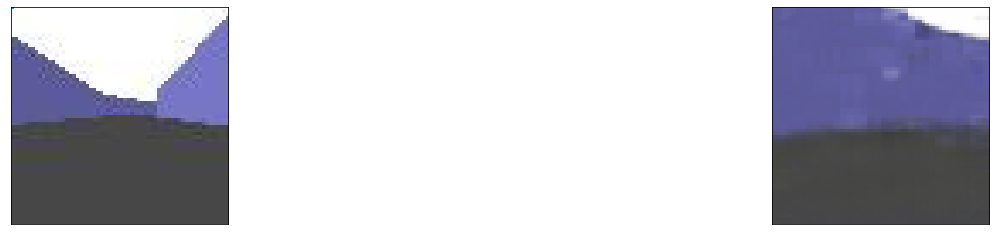

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(25,4))
obs = obs[0,:,:,:].cpu()*255
obs = trans_To_Pil(obs)
axes[0].imshow(np.squeeze(obs))
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)

decoded = decoded[0,:,:,:].cpu()
decoded = trans_To_Pil(decoded)
axes[1].imshow(np.squeeze(decoded))
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)